In [1]:
from SimPEG import Mesh, Maps
import numpy as np
from matplotlib.colors import LogNorm
from simpegEM1D import (
    GlobalEM1DProblemTD, GlobalEM1DSurveyTD, get_vertical_discretization_time, EM1DSurveyTD
)
from pymatsolver import PardisoSolver
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Seting up a 2D mesh and model

In [2]:
from simpegEM1D import skytem_HM_2015
wave = skytem_HM_2015()
time = np.logspace(-5, -2, 21)
hz = get_vertical_discretization_time(time, facter_tmax=0.5, factor_tmin=10.)
time_input_currents = wave.current_times[-7:]
input_currents = wave.currents[-7:]

In [3]:
from scipy.spatial import Delaunay
def PolygonInd(mesh, pts):
    hull = Delaunay(pts)
    inds = hull.find_simplex(mesh.gridCC)>=0
    return inds

In [4]:
n_sounding = 20
dx = 20.
hx = np.ones(n_sounding) * dx
mesh = Mesh.TensorMesh([hx, hz], x0='00')
inds =  mesh.gridCC[:,1]<25
sigma = np.ones(mesh.nC) * 1./100.
sigma[inds] = 1./50.
x0 = np.r_[0., 75.]
x1 = np.r_[dx*n_sounding, 75.]
x2 = np.r_[dx*n_sounding, 90.]
x3 = np.r_[0., 200.]
pts = np.vstack((x0, x1, x2, x3, x0))
poly_inds = PolygonInd(mesh, pts)
sigma[poly_inds] = 0.1
sigma_em1d = sigma.reshape(mesh.vnC, order='F').flatten()

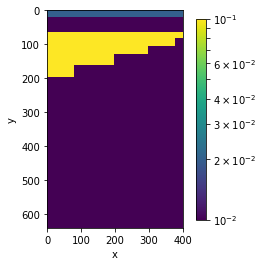

In [5]:
cb = plt.colorbar(
    mesh.plotImage(sigma, grid=False, clim=(1e-2, 1e-1),pcolorOpts={"norm":LogNorm()})[0],
    fraction=0.03, pad=0.04
)

plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(1)

In [6]:
x = mesh.vectorCCx
y = np.zeros_like(x)
z = np.ones_like(x) * 30.
rx_locations = np.c_[x, y, z]
src_locations = np.c_[x, y, z]
topo = np.c_[x, y, z-30.].astype(float)

In [7]:
mapping = Maps.ExpMap(mesh)

In [8]:
survey = GlobalEM1DSurveyTD(
    rx_locations = rx_locations,
    src_locations = src_locations,    
    topo = topo,
    time = time,
    src_type = "CircularLoop",
    rx_type = "dBzdt",    
    field_type = 'secondary',
    wave_type = 'general',    
    a = 13.,
    input_currents=[input_currents for i in range(n_sounding)],
    time_input_currents=[time_input_currents for i in range(n_sounding)],
    n_pulse = 1,
    base_frequency = 20.,
)

prob = GlobalEM1DProblemTD(
    [], sigmaMap=mapping, hz=hz, parallel=True, n_cpu=2,
    Solver=PardisoSolver
)
prob.pair(survey)

ValueError: The 'offset' property of a GlobalEM1DSurveyTD instance must be a list or numpy array of <class 'float'> with shape (\*, \*). An array of shape (1,) and dtype float64 was specified. 

In [ ]:
m = np.log(sigma_em1d)

In [ ]:
%%time
dobs = survey.makeSyntheticData(m, std=0.05, force=True)

In [ ]:
DOBS = dobs.reshape(( prob.n_sounding, survey.n_time))

In [ ]:
for i_time in range(survey.n_time):
    plt.semilogy(mesh.vectorCCx, -DOBS[:,i_time], 'k')

In [ ]:
from SimPEG import (
    Regularization, Directives, Inversion, InvProblem, Optimization, DataMisfit, Utils
)

In [ ]:
mesh_reg = Mesh.TensorMesh([mesh.hy, mesh.hx])

In [ ]:
%%time
std = 0.05
floor = 0.
np.random.seed(1)
uncert = std*abs(dobs)+floor
survey.dobs = dobs.copy()
m0 = np.ones(mesh.nC) * np.log(1./100.)
dmisfit = DataMisfit.l2_DataMisfit(survey)
regmap = Maps.IdentityMap(mesh)
# mapping is required ... for IRLS
reg = Regularization.Sparse(
    mesh_reg, mapping=regmap,
    alpha_s=1.,
    alpha_x = 2.,
    alpha_y = 2.,    
)
p = 0
qx, qz = 1., 1.
reg.norms = np.c_[p, qx, qz, 0.]
IRLS = Directives.Update_IRLS(
    maxIRLSiter=5, minGNiter=1, fix_Jmatrix=True,
    betaSearch=False
)
opt = Optimization.InexactGaussNewton(maxIter = 20)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=1)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1.)
target = Directives.TargetMisfit()
# inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest,target])
inv = Inversion.BaseInversion(invProb, directiveList=[IRLS,betaest])
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mopt = inv.run(m0)

In [ ]:
sigma_est = Utils.mkvc((np.exp(mopt)).reshape((prob.n_sounding, prob.n_layer)))
sigma_est_l2 = Utils.mkvc((np.exp(invProb.l2model)).reshape((prob.n_sounding, prob.n_layer)))

In [ ]:
import matplotlib
matplotlib.rcParams['font.size'] = 14

In [ ]:
cb = plt.colorbar(
    mesh.plotImage(
        sigma, grid=True, clim=(1e-2, 1e-1),pcolorOpts={"norm":LogNorm()},
        gridOpts={'alpha':0.2, 'color':'grey'}
    )[0],
    fraction=0.02, pad=0.04
)

plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(1)

plt.title("True model")

cb = plt.colorbar(
    mesh.plotImage(
        sigma_est_l2, grid=True, clim=(1e-2, 1e-1),pcolorOpts={"norm":LogNorm()},
        gridOpts={'alpha':0.2, 'color':'grey'}
    )[0],
    fraction=0.02, pad=0.04
)
plt.title("Laterally-contrained model: L2 L2")
plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(1)


cb = plt.colorbar(
    mesh.plotImage(
        sigma_est, grid=True, clim=(1e-2, 1e-1), pcolorOpts={"norm":LogNorm()},
        gridOpts={'alpha':0.2, 'color':'grey'}
    )[0],
    fraction=0.02, pad=0.04
)
plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(1)
plt.title("Laterally-contrained model: L0 L2")

In [ ]:
PRED = invProb.dpred.reshape((prob.n_sounding, survey.n_time))

In [ ]:
for i_time in range(survey.n_time):
    plt.semilogy(mesh.vectorCCx, -DOBS[:,i_time], 'k')
    plt.semilogy(mesh.vectorCCx, -PRED[:,i_time], 'kx', ms=1)